In [6]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

Config

In [11]:
IMG_SIZE = 224
BATCH_SIZE = 32
INITIAL_EPOCHS = 50
FINE_TUNE_EPOCHS = 70
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

ORIG_DATA_DIR = r'E:\Krishi-Sahayak\krishi-model\Data'  # original dataset folder
DATA_DIR = r'E:\Krishi-Sahayak\krishi-model\SplitData' # folder where split dataset will be saved

Split Data

In [8]:
def split_data(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=42):
    random.seed(seed)
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

    classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    print(f"Classes found: {classes}")

    for cls in classes:
        cls_path = os.path.join(source_dir, cls)
        files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
        random.shuffle(files)

        n_total = len(files)
        n_train = int(train_ratio * n_total)
        n_val = int(val_ratio * n_total)
        n_test = n_total - n_train - n_val

        splits = {
            'train': files[:n_train],
            'val': files[n_train:n_train+n_val],
            'test': files[n_train+n_val:]
        }

        for split_name, split_files in splits.items():
            split_dir = os.path.join(dest_dir, split_name, cls)
            os.makedirs(split_dir, exist_ok=True)

            for file_name in split_files:
                src_file = os.path.join(cls_path, file_name)
                dst_file = os.path.join(split_dir, file_name)
                if not os.path.exists(dst_file):
                    shutil.copy2(src_file, dst_file)
            print(f"Copied {len(split_files)} files to {split_dir}")

In [ ]:
# split_data(ORIG_DATA_DIR, DATA_DIR, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2)

Classes found: ['Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy', 'Corn___Northern_Leaf_Blight', 'Potato___Early_Blight', 'Potato___Healthy', 'Potato___Late_Blight', 'Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Leaf_Blast', 'Rice___Neck_Blast', 'Sugarcane_Bacterial Blight', 'Sugarcane_Healthy', 'Sugarcane_Red Rot', 'Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']
Copied 715 files to E:\Krishi-Sahayak\krishi-model\SplitData\train\Corn___Common_Rust
Copied 238 files to E:\Krishi-Sahayak\krishi-model\SplitData\val\Corn___Common_Rust
Copied 239 files to E:\Krishi-Sahayak\krishi-model\SplitData\test\Corn___Common_Rust
Copied 307 files to E:\Krishi-Sahayak\krishi-model\SplitData\train\Corn___Gray_Leaf_Spot
Copied 102 files to E:\Krishi-Sahayak\krishi-model\SplitData\val\Corn___Gray_Leaf_Spot
Copied 104 files to E:\Krishi-Sahayak\krishi-model\SplitData\test\Corn___Gray_Leaf_Spot
Copied 697 files to E:\Krishi-Sahayak\krishi-model\SplitData\train\Corn___Healthy
C

Data Generators

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'test'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Save labels for inference
os.makedirs("model", exist_ok=True)
with open("model/labels.txt", "w") as f:
    for label in train_generator.class_indices:
        f.write(f"{label}\n")

Found 7990 images belonging to 17 classes.
Found 2660 images belonging to 17 classes.
Found 2674 images belonging to 17 classes.


Build Model

In [13]:
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

# Freeze the base model initially
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint('model/best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

Initial training

In [16]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=INITIAL_EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.7624 - loss: 0.7465
Epoch 1: val_loss improved from inf to 0.33019, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.7626 - loss: 0.7460 - val_accuracy: 0.8703 - val_loss: 0.3302 - learning_rate: 0.0010
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.8602 - loss: 0.3968
Epoch 2: val_loss did not improve from 0.33019
250/250 ━━━━━━━━━━━━━━━━━━━━ 232s 929ms/step - accuracy: 0.8602 - loss: 0.3968 - val_accuracy: 0.8786 - val_loss: 0.3321 - learning_rate: 0.0010
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.8649 - loss: 0.3548
Epoch 3: val_loss improved from 0.33019 to 0.29387, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 237s 950ms/step - accuracy: 0.8649 - loss: 0.3548 - val_accuracy: 0.8895 - val_loss: 0.2939 - learning_rate: 0.0010
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 765ms/step - accuracy: 0.8680 - loss: 0.3370
Epoch 4: val_loss improved from 0.29387 to 0.27326, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 236s 944ms/step - accuracy: 0.8680 - loss: 0.3370 - val_accuracy: 0.8962 - val_loss: 0.2733 - learning_rate: 0.0010
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.8908 - loss: 0.2880
Epoch 5: val_loss did not improve from 0.27326
250/250 ━━━━━━━━━━━━━━━━━━━━ 239s 958ms/step - accuracy: 0.8908 - loss: 0.2881 - val_accuracy: 0.8880 - val_loss: 0.2887 - learning_rate: 0.0010
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.8827 - loss: 0.3119
Epoch 6: val_loss improved from 0.27326 to 0.26709, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 235s 939ms/step - accuracy: 0.8828 - loss: 0.3118 - val_accuracy: 0.8966 - val_loss: 0.2671 - learning_rate: 0.0010
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.8928 - loss: 0.2845
Epoch 7: val_loss did not improve from 0.26709
250/250 ━━━━━━━━━━━━━━━━━━━━ 243s 973ms/step - accuracy: 0.8928 - loss: 0.2845 - val_accuracy: 0.8887 - val_loss: 0.2975 - learning_rate: 0.0010
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.9039 - loss: 0.2551
Epoch 8: val_loss did not improve from 0.26709
250/250 ━━━━━━━━━━━━━━━━━━━━ 250s 1000ms/step - accuracy: 0.9039 - loss: 0.2551 - val_accuracy: 0.8944 - val_loss: 0.2785 - learning_rate: 0.0010
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.9035 - loss: 0.2584
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 9: val_loss did not improve from 0.26709
250/250 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.9034 - loss: 0.2584 - val_

250/250 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.9202 - loss: 0.2048 - val_accuracy: 0.9064 - val_loss: 0.2438 - learning_rate: 5.0000e-04
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.9242 - loss: 0.1967
Epoch 12: val_loss did not improve from 0.24380
250/250 ━━━━━━━━━━━━━━━━━━━━ 244s 977ms/step - accuracy: 0.9241 - loss: 0.1968 - val_accuracy: 0.9079 - val_loss: 0.2440 - learning_rate: 5.0000e-04
Epoch 13/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.9138 - loss: 0.2156
Epoch 13: val_loss did not improve from 0.24380
250/250 ━━━━━━━━━━━━━━━━━━━━ 247s 989ms/step - accuracy: 0.9138 - loss: 0.2156 - val_accuracy: 0.8981 - val_loss: 0.2689 - learning_rate: 5.0000e-04
Epoch 14/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.9134 - loss: 0.2085
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: val_loss did not improve from 0.24380
250/250 ━━━━━━━━━━━━━━━━━━━━ 248s 990ms/step - accuracy: 0.9134 - l

250/250 ━━━━━━━━━━━━━━━━━━━━ 252s 1s/step - accuracy: 0.9243 - loss: 0.1948 - val_accuracy: 0.9071 - val_loss: 0.2415 - learning_rate: 2.5000e-04
Epoch 18/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.9360 - loss: 0.1629
Epoch 18: val_loss did not improve from 0.24150
250/250 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.9360 - loss: 0.1630 - val_accuracy: 0.9098 - val_loss: 0.2467 - learning_rate: 2.5000e-04
Epoch 19/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.9320 - loss: 0.1651
Epoch 19: val_loss did not improve from 0.24150
250/250 ━━━━━━━━━━━━━━━━━━━━ 249s 998ms/step - accuracy: 0.9320 - loss: 0.1652 - val_accuracy: 0.9117 - val_loss: 0.2452 - learning_rate: 2.5000e-04
Epoch 20/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.9313 - loss: 0.1671
Epoch 20: val_loss improved from 0.24150 to 0.23956, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 238s 953ms/step - accuracy: 0.9313 - loss: 0.1672 - val_accuracy: 0.9079 - val_loss: 0.2396 - learning_rate: 2.5000e-04
Epoch 21/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.9341 - loss: 0.1641
Epoch 21: val_loss did not improve from 0.23956
250/250 ━━━━━━━━━━━━━━━━━━━━ 246s 984ms/step - accuracy: 0.9341 - loss: 0.1641 - val_accuracy: 0.9128 - val_loss: 0.2442 - learning_rate: 2.5000e-04
Epoch 22/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.9305 - loss: 0.1736
Epoch 22: val_loss improved from 0.23956 to 0.23056, saving model to model/best_model.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 253s 1s/step - accuracy: 0.9305 - loss: 0.1736 - val_accuracy: 0.9139 - val_loss: 0.2306 - learning_rate: 2.5000e-04
Epoch 23/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.9368 - loss: 0.1612
Epoch 23: val_loss did not improve from 0.23056
250/250 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.9368 - loss: 0.1612 - val_accuracy: 0.9113 - val_loss: 0.2407 - learning_rate: 2.5000e-04
Epoch 24/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.9330 - loss: 0.1709
Epoch 24: val_loss did not improve from 0.23056
250/250 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.9330 - loss: 0.1708 - val_accuracy: 0.9143 - val_loss: 0.2317 - learning_rate: 2.5000e-04
Epoch 25/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.9316 - loss: 0.1699
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 25: val_loss did not improve from 0.23056
250/250 ━━━━━━━━━━━━━━━━━━━━ 232s 926ms/step - accuracy: 0.9316 - loss: 0

Fine-tuning

In [17]:
# Unfreeze the top layers of the base model for fine-tuning
for layer in base_model.layers[-50:]:  # unfreeze last 50 layers (can tune this)
    layer.trainable = True

# Compile again with lower LR
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=[early_stopping, checkpoint]
)

Epoch 30/120
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.8640 - loss: 0.3904
Epoch 30: val_loss did not improve from 0.23056
250/250 ━━━━━━━━━━━━━━━━━━━━ 297s 1s/step - accuracy: 0.8641 - loss: 0.3902 - val_accuracy: 0.7684 - val_loss: 1.0247
Epoch 31/120
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 983ms/step - accuracy: 0.9083 - loss: 0.2564
Epoch 31: val_loss did not improve from 0.23056
250/250 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.9084 - loss: 0.2564 - val_accuracy: 0.8346 - val_loss: 0.5687
Epoch 32/120
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9207 - loss: 0.2229
Epoch 32: val_loss did not improve from 0.23056
250/250 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.9207 - loss: 0.2228 - val_accuracy: 0.8759 - val_loss: 0.4229
Epoch 33/120
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9381 - loss: 0.1683
Epoch 33: val_loss did not improve from 0.23056
250/250 ━━━━━━━━━━━━━━━━━━━━ 300s 1s/step - accuracy: 0.9381 - loss: 0.1684 - val_accuracy: 0.8925 -

Plot Training Results

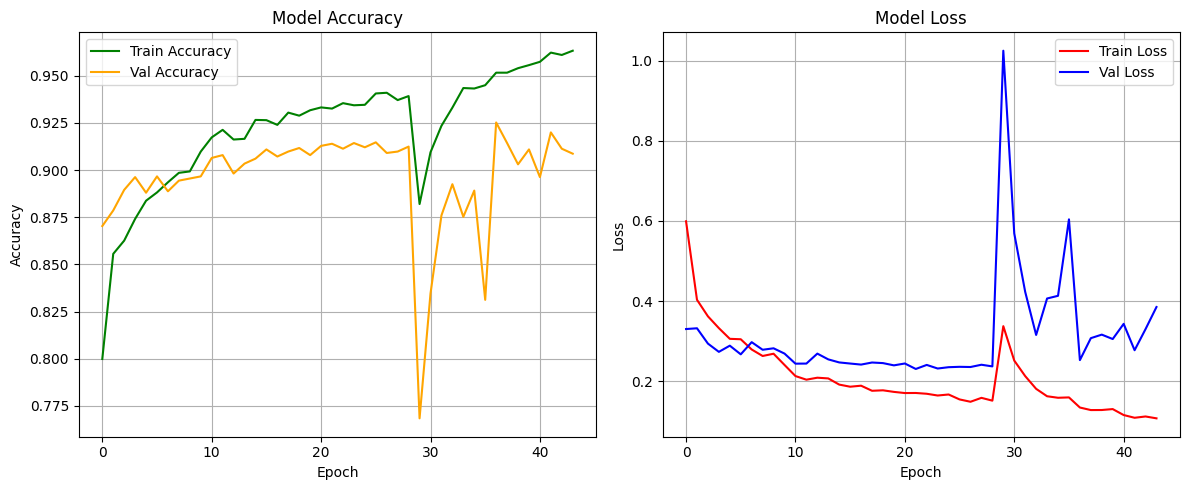

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Val Loss', color='blue')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Evaluate on test set

In [ ]:
print("\nEvaluating on test data...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc*100:.2f}, Test Loss: {test_loss:.2f}")


Evaluating on test data...
84/84 ━━━━━━━━━━━━━━━━━━━━ 53s 628ms/step - accuracy: 0.9462 - loss: 0.1678
Test accuracy: 92.37, Test Loss: 0.26%
